In [164]:
# spestana@uw.edu

In [136]:
import scipy.io
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot

import os
import logging

import numpy as np

import pandas as pd
import seaborn as sns

from matplotlib.colors import LogNorm
from osgeo import gdal
from numpy import ma

import datetime as dt

%matplotlib inline

## Define some plotting functions

In [159]:
def plot(array, label=None):
    """Plot a numpy array with a colorbar."""
    plt.imshow(array)
    plt.colorbar()
    if label is None:
        label = 'Raster {}'.format(array.shape)
    plt.title(label)
    plt.xlabel('Column #')
    plt.ylabel('Row #')
    
def bigmap(array, label=None, xlabel=None, ylabel=None):
    """Plot a numpy array with a colorbar."""
    plt.figure(num=None, figsize=(15, 12))
    #rasterio.plot.show(array, cmap = 'gist_earth')
    plt.imshow(array, cmap = 'gist_earth')
    plt.colorbar()
    if label is None:
        label = 'Raster {}'.format(array.shape)
    plt.title(label)
    if xlabel is None:
        xlabel = 'Column #'
    if ylabel is None:
        ylabel = 'Row #'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

## Set directories, filenames, specify year for snowdepth

In [139]:
# Set local data directories
homedir = r'C:\Users\steve\git\ghw2018_snowmelt\ghw2018_snowmelt_data'
depthdir = r'C:\Users\steve\git\ghw2018_snowmelt\ghw2018_snowmelt_data\snow_depth_mean30m\2014\\'

# 30 m DEM
dem_loc = 'dem30m.tif'
dem_file = f'{homedir}/{dem_loc}'

# Watershed boundary mask
mask = 'scene_30m_mask.tif'
mask_file = f'{homedir}/{mask}'

# Forest cover mask
veg = 'no_veg_bin30res.tif'
veg_file = f'{homedir}/{veg}'


## Load snow depth files for a single year

In [140]:
# file extension to detect in this directory
extension = '.tif'

with rasterio.open(mask_file) as m:
    mask_values = m.read(1)

# load all the snow depth tif files that are in the directory specified
file = 1;
obs_dates = [];
for root, dirs_list, files_list in os.walk(depthdir):
    for file_name in files_list:
        if os.path.splitext(file_name)[-1] == extension:
            file_name_path = os.path.join(root, file_name)
            #print(file_name[2:9])
            #print(file_name_path)   # This is the full path of the file
            current_date = dt.datetime.strptime(file_name[2:10], '%Y%m%d')
            obs_dates.append(current_date);
            with rasterio.open(file_name_path) as snowdepthfile:
                current_image = snowdepthfile.read(1)
                if file == 1:
                    # if this is the first image, then create the data array with the first image
                    snowdepth = current_image * mask_values;
                else:
                    # if this is not the first image, add this new image to the array containing the previous ones
                    snowdepth = np.dstack((snowdepth,current_image * mask_values))
            file = file + 1; # increment the file counter
#snowdepth = np.nan_to_num(snowdepth)
diff = np.diff(snowdepth,n=1,axis=2)
diff[abs(diff) < 0.001] = np.nan


# look at their shapes, diff should be 1 less in the 3rd dimension
print(snowdepth.shape)
print(diff.shape)

(1684, 1777, 11)
(1684, 1777, 10)


C:\Users\steve\Anaconda3\envs\ghw2018_snowmelt\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


## Plot diff maps and histograms

C:\Users\steve\Anaconda3\envs\ghw2018_snowmelt\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


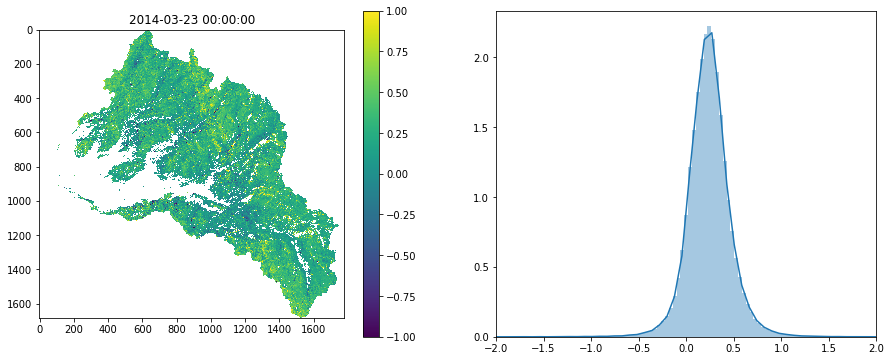

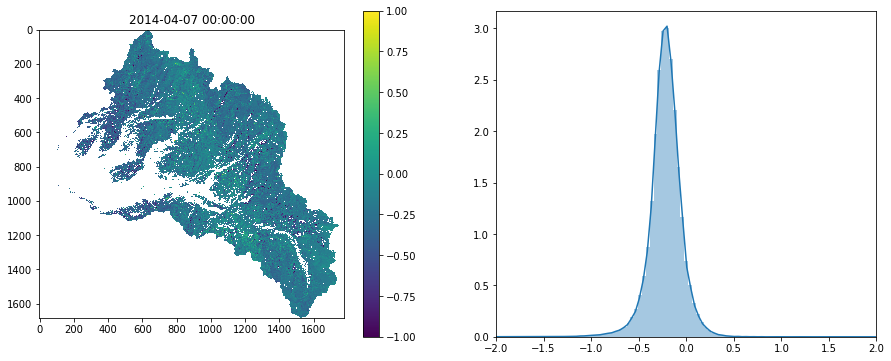

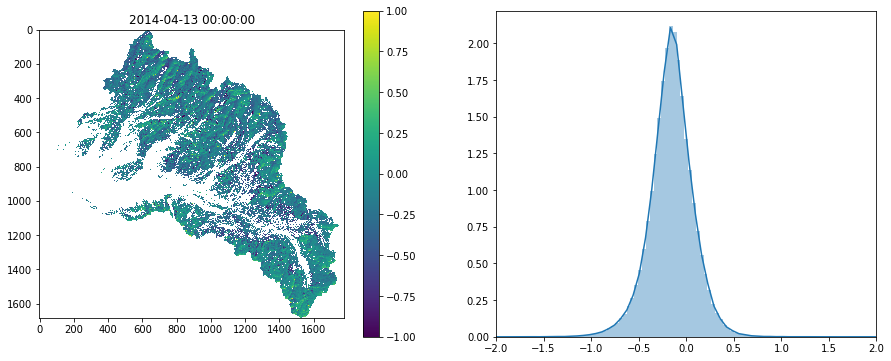

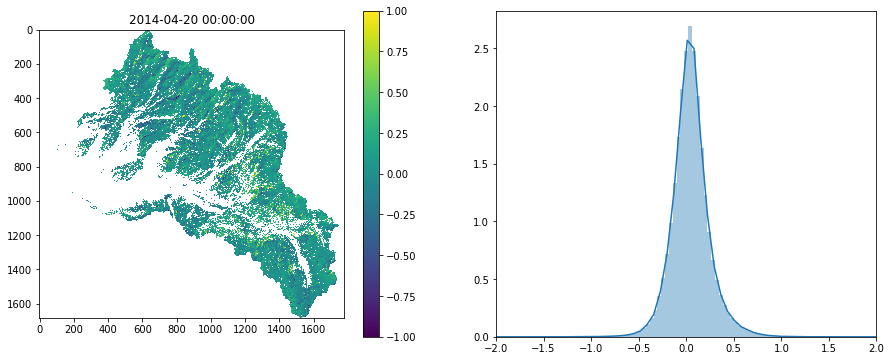

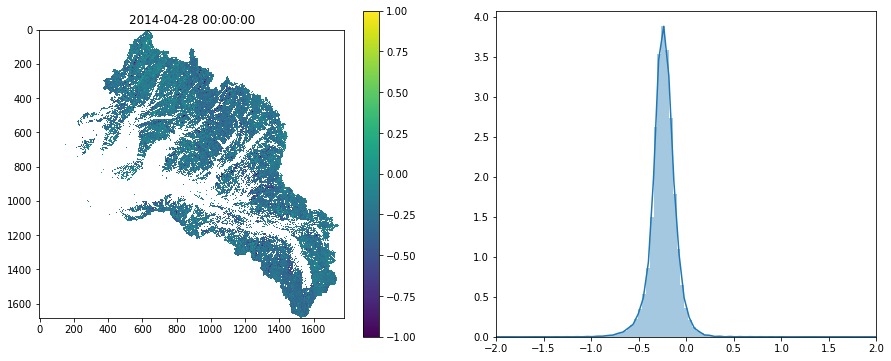

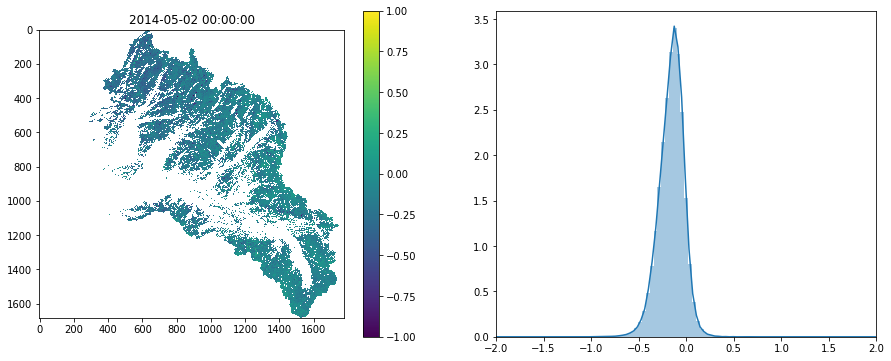

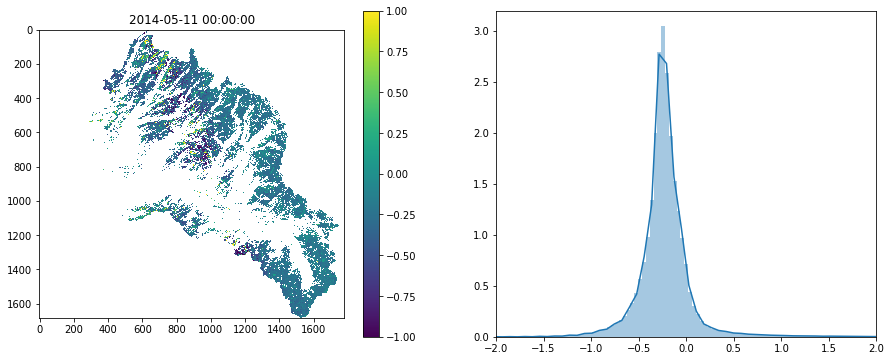

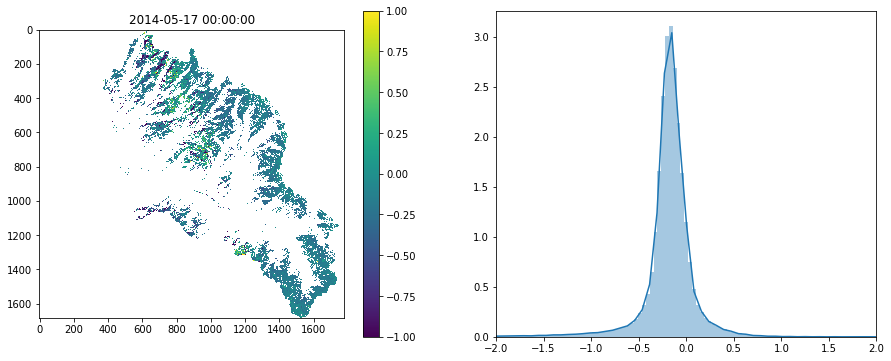

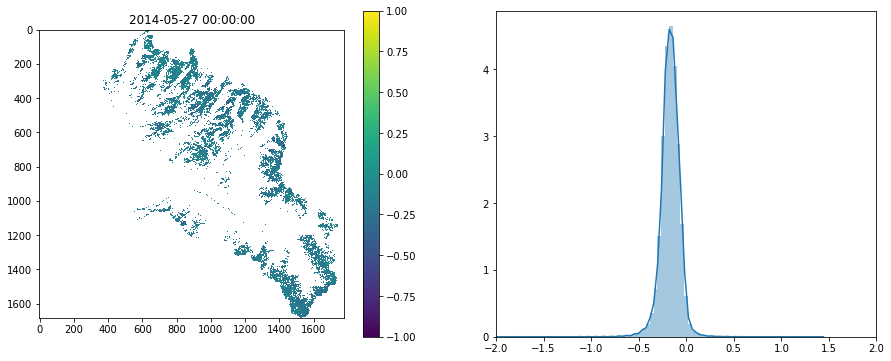

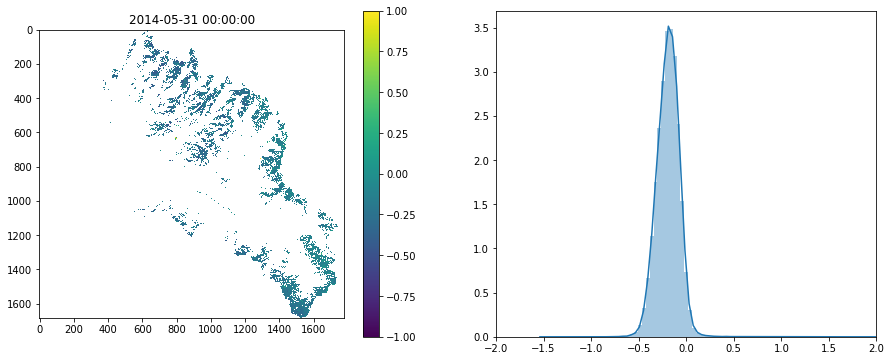

In [153]:
for i in range(0,diff.shape[2]):
    plt.figure(i,figsize=(15,6))
    plt.subplot(121)
    plt.imshow(diff[:,:,i],vmin=-1,vmax=1)
    plt.title(obs_dates[i])
    plt.colorbar()
    plt.subplot(122)
    sns.distplot(diff[:,:,i][~np.isnan(diff[:,:,i])],bins = np.linspace(-2,2,100))
    plt.xlim((-2,2))
    #plt.hist(diff[:,:,i][~np.isnan(diff[:,:,i])],bins = np.linspace(-2,2,200))


## Calculate basin-wide snowdepth and diff means and totals

In [160]:

snowdepth_means = [];
snowdepth_sums = [];
diff_means = [];
diff_sums = [];

for i in range(0,diff.shape[2]):
    diff_means.append(np.mean(diff[:,:,i][~np.isnan(diff[:,:,i])]))
    diff_sums.append(np.sum(diff[:,:,i][~np.isnan(diff[:,:,i])]))
    
for i in range(0,snowdepth.shape[2]):
    snowdepth_means.append(np.mean(snowdepth[:,:,i][~np.isnan(snowdepth[:,:,i])]))
    snowdepth_sums.append(np.sum(snowdepth[:,:,i][~np.isnan(snowdepth[:,:,i])]))

## Plot the mean snowdepth and the mean difference in snowdepth over time (2014)

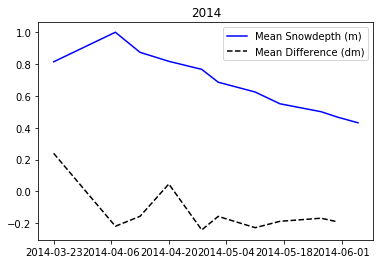

In [161]:
#plt.plot(obs_dates,snowdepth_means,'.k')
plt.plot(obs_dates,snowdepth_means,'-b',label='Mean Snowdepth (m)')

plt.plot(obs_dates[:-1],diff_means,'--k',label='Mean Difference (dm)')

plt.legend()
plt.title("2014");

## Display the DEM and basin mask files

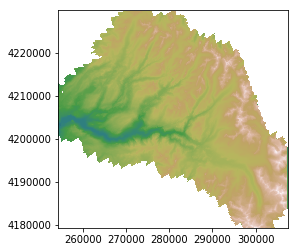

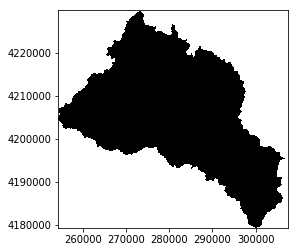

In [162]:
with rasterio.open(dem_file) as d:
    dem_values = d.read(1)
    rasterio.plot.show(d, cmap="gist_earth")
    
with rasterio.open(mask_file) as m:
    mask_values = m.read(1)
    rasterio.plot.show(m, cmap="gist_earth")
    
masked_dem = mask_values * dem_values;

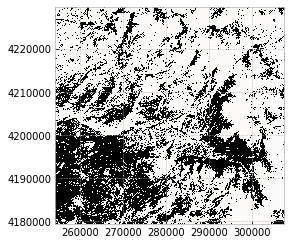

In [95]:
with rasterio.open(veg_file) as v:
    veg_values = v.read(1)
    rasterio.plot.show(v, cmap="gist_earth")
    

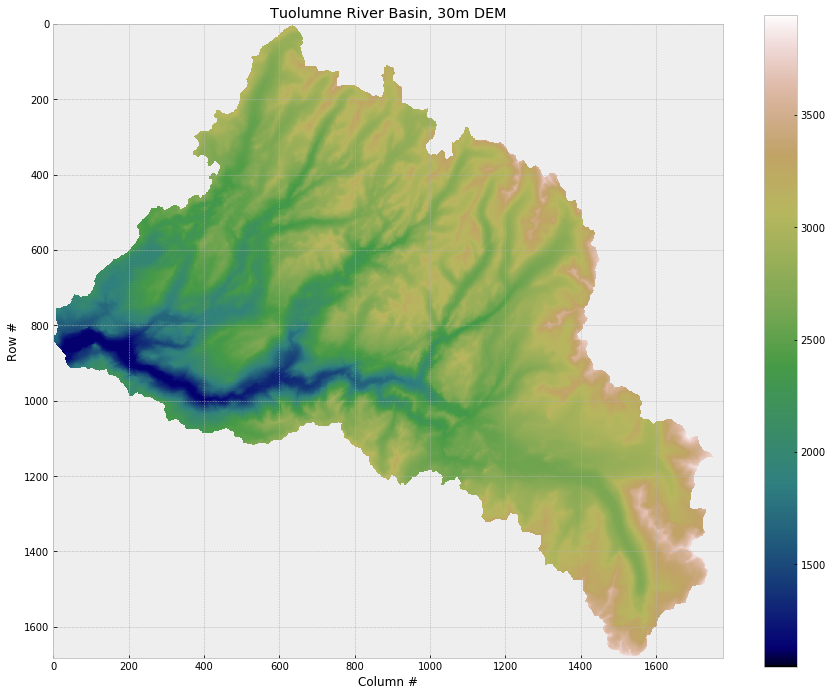

In [97]:
bigmap(masked_dem, "Tuolumne River Basin, 30m DEM")